<span style="font-size:27px; color:blue">**Time Series Analysis**</span>

## Import Necessary Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Exploratory Data Analysis (EDA)

In [4]:
file_path = "C:\\Users\\Zuu Zuu Kyaw Shwe\\Desktop\\Statistics and Optimisation\\CA\\ts5.csv"
ts_data = pd.read_csv(file_path)
ts_data.head()

,Unnamed: 0,x
0,1,371.333344
1,2,402.863342
2,3,390.666656
3,4,404.619995
4,5,409.970001


In [6]:
# Check data's info
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  401 non-null    int64  
 1   x           401 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 6.4 KB


In [8]:
# Check for missing values
missing_values = ts_data.isnull().sum()
missing_values

Unnamed: 0    0
x             0
dtype: int64

In [10]:
# Rename columns
ts_data.columns = ['Time','Value']

# Set the 'Time' column as the index to reflect the sequential order of the time series
ts_data.set_index("Time", inplace=True)
ts_data.head()

,Value
Time,
1,371.333344
2,402.863342
3,390.666656
4,404.619995
5,409.970001


In [12]:
# Check for duplicates in the dataset
ts_data.duplicated().sum()

2

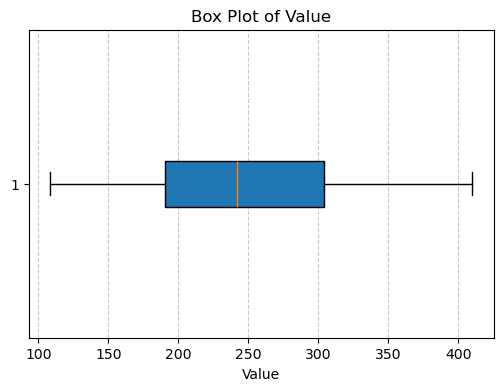

In [14]:
# Create a box plot for the 'Value' column to detect outliers
plt.figure(figsize=(6, 4))
plt.boxplot(ts_data['Value'], vert=False, patch_artist=True)
plt.title('Box Plot of Value')
plt.xlabel('Value')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [16]:
# Summarize the data to check for basic statistical properties
ts_data.describe()

,Value
count,401.000000
mean,250.395744
std,71.709081
min,108.099998
25%,190.720001
50%,241.866669
75%,303.996674
max,409.970001


## Data Splitting

In [19]:
# Define the split ratio
train_size = int(len(ts_data) * 0.8)

# Split the data into training and testing sets
train_data = ts_data.iloc[:train_size]
test_data = ts_data.iloc[train_size:]

## Data Visualization

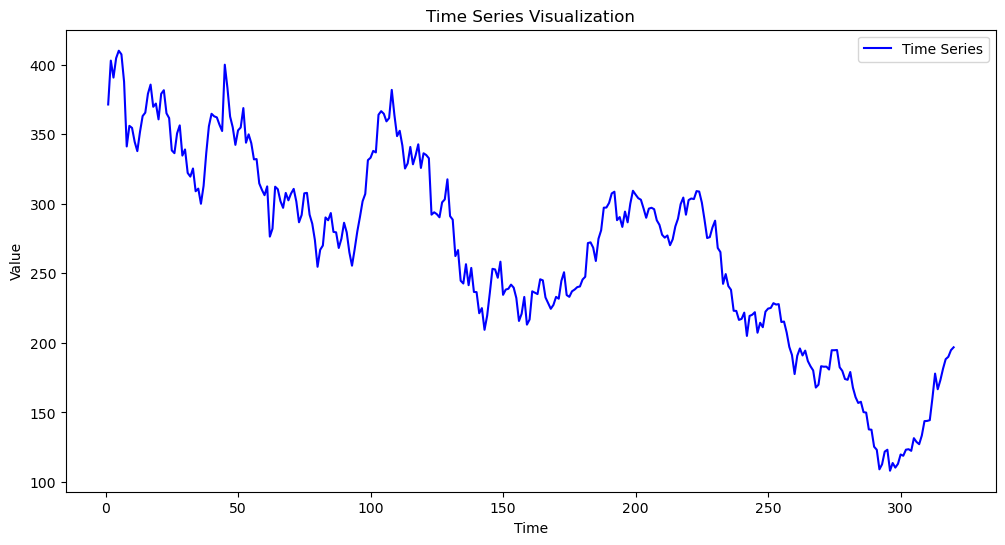

In [22]:
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Value'], label='Time Series', color='blue')
plt.title('Time Series Visualization')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

## Data Decomposing

<Figure size 1200x800 with 0 Axes>

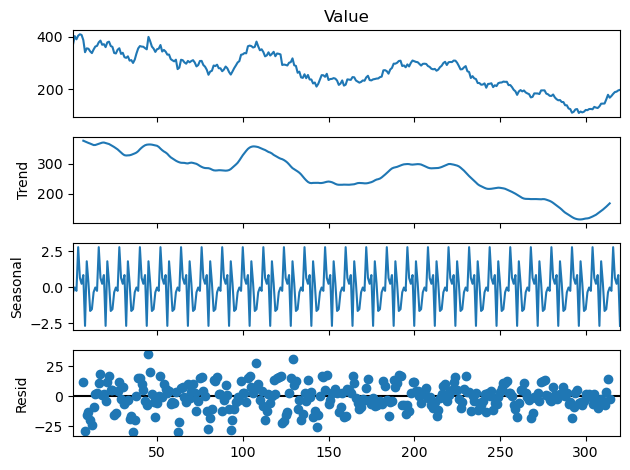

In [25]:
# Decompose the time series to observe trends, seasonality, and residuals
decomposition = seasonal_decompose(train_data['Value'], model='additive', period=12)
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

## Stationary Test

In [28]:
# Perform the Augmented Dickey-Fuller (ADF) test
adf_test_result = adfuller(train_data['Value'])

adf_test_summary = {
    "ADF Statistic": adf_test_result[0],
    "p-value": adf_test_result[1],
    "Critical Values": adf_test_result[4],
    "Stationarity Conclusion": "Non-stationary" if adf_test_result[1] > 0.05 else "Stationary"
}
adf_test_summary

{'ADF Statistic': -1.6286681325611205,
 'p-value': 0.46818794259860014,
 'Critical Values': {'1%': -3.451621854687657,
  '5%': -2.870908950689806,
  '10%': -2.571761810613944},
 'Stationarity Conclusion': 'Non-stationary'}

## Data Transformation 

In [31]:
# Apply first-order differencing to achieve stationarity
train_data['Differenced'] = train_data['Value'].diff()

# Drop the NaN value created by differencing
differenced_data = train_data['Differenced'].dropna()

# Perform the ADF test again on the differenced series
adf_test_differenced_result = adfuller(differenced_data)

adf_test_differenced_summary = {
    "ADF Statistic": adf_test_differenced_result[0],
    "p-value": adf_test_differenced_result[1],
    "Critical Values": adf_test_differenced_result[4],
    "Stationarity Conclusion": "Non-stationary" if adf_test_differenced_result[1] > 0.05 else "Stationary"
}
adf_test_differenced_summary

{'ADF Statistic': -5.567283114162248,
 'p-value': 1.4947893806162113e-06,
 'Critical Values': {'1%': -3.45169128009473,
  '5%': -2.8709394227049154,
  '10%': -2.5717780602423517},
 'Stationarity Conclusion': 'Stationary'}

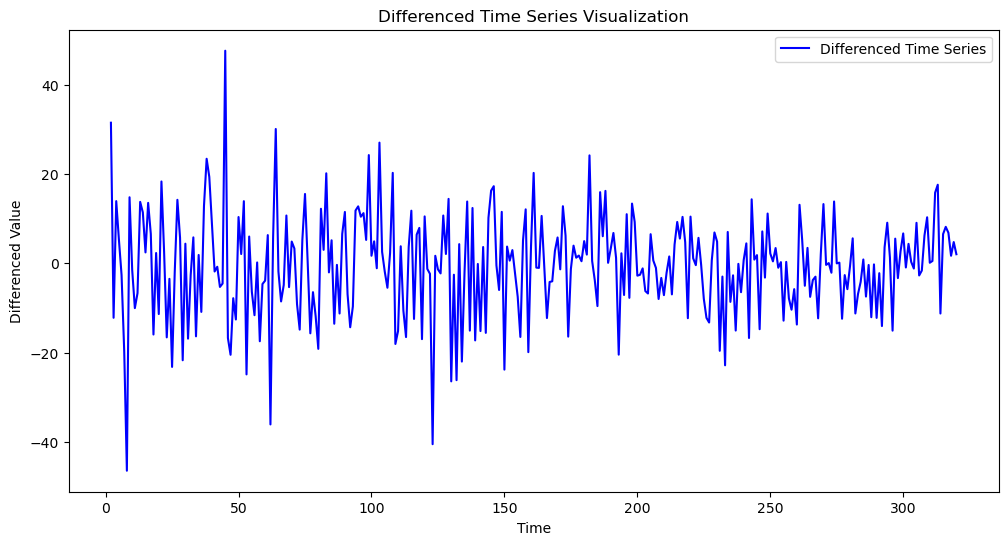

In [33]:
# Plot the differenced time series to visually confirm stationarity
plt.figure(figsize=(12, 6))
plt.plot(differenced_data, label='Differenced Time Series', color='blue')
plt.title('Differenced Time Series Visualization')
plt.xlabel('Time')
plt.ylabel('Differenced Value')
plt.legend()
plt.show()

## ACF & PACF Plots

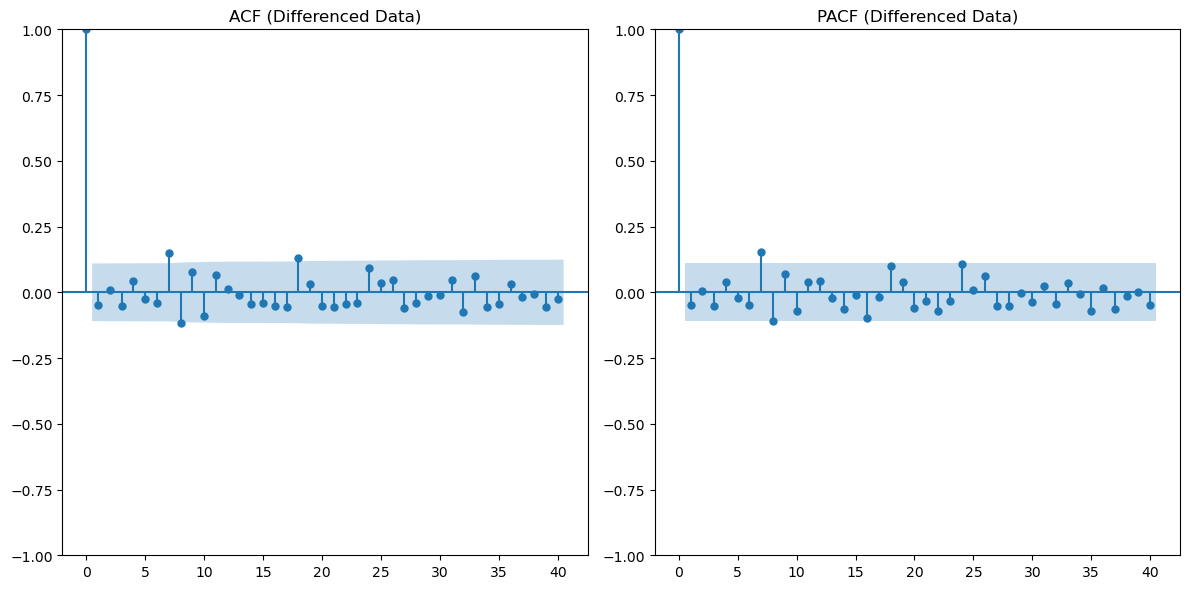

In [36]:
plt.figure(figsize=(12, 6))

# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(differenced_data, lags=40, ax=plt.gca(), title="ACF (Differenced Data)")

# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(differenced_data, lags=40, ax=plt.gca(), title="PACF (Differenced Data)")

plt.tight_layout()
plt.show()

## Models Fitting

In [38]:
auto_arima(train_data["Value"])

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [40]:
# Fit an ARIMA(0,1,0) model
arima_model_0_1_0 = ARIMA(train_data['Value'], order=(0, 1, 0))
arima_result_0_1_0 = arima_model_0_1_0.fit()

arima_summary_0_1_0 = arima_result_0_1_0.summary()
arima_summary_0_1_0

C:\Users\Zuu Zuu Kyaw Shwe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Zuu Zuu Kyaw Shwe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Zuu Zuu Kyaw Shwe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                  320
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1230.493
Date:                Sat, 30 Nov 2024   AIC                           2462.986
Time:                        14:37:12   BIC                           2466.751
Sample:                             0   HQIC                          2464.489
                                - 320                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       131.2170      7.668     17.113      0.000     116.189     146.245
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):                37.51
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
# Fit an ARIMA(1,1,1) model
arima_model_1_1_1 = ARIMA(train_data['Value'], order=(1, 1, 1))
arima_result_1_1_1 = arima_model_1_1_1.fit()

arima_summary_1_1_1 = arima_result_1_1_1.summary()
arima_summary_1_1_1

C:\Users\Zuu Zuu Kyaw Shwe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Zuu Zuu Kyaw Shwe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Zuu Zuu Kyaw Shwe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                  320
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1230.017
Date:                Sat, 30 Nov 2024   AIC                           2466.034
Time:                        14:37:16   BIC                           2477.330
Sample:                             0   HQIC                          2470.545
                                - 320                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5383      0.739     -0.728      0.466      -1.987       0.910
ma.L1          0.4915      0.772      0.637      0.524      -1.021       2.004
sigma2       130.8183      7.648     17.105      0.000     115.829     145.808
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                40.35
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
# Fit an ARIMA(2,1,1) model
arima_model_2_1_1 = ARIMA(train_data['Value'], order=(2, 1, 1))
arima_result_2_1_1 = arima_model_2_1_1.fit()

arima_summary_2_1_1 = arima_result_2_1_1.summary()
arima_summary_2_1_1

C:\Users\Zuu Zuu Kyaw Shwe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Zuu Zuu Kyaw Shwe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Zuu Zuu Kyaw Shwe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                  320
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1230.010
Date:                Sat, 30 Nov 2024   AIC                           2468.020
Time:                        14:37:19   BIC                           2483.080
Sample:                             0   HQIC                          2474.034
                                - 320                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5124      1.282     -0.400      0.689      -3.025       2.000
ar.L2          0.0077      0.091      0.084      0.933      -0.170       0.185
ma.L1          0.4688      1.285      0.365      0.715      -2.050       2.988
sigma2       130.8124      7.664     17.069      0.000     115.792     145.833
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                40.24
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
# Fit an ARIMA(1,1,2) model
arima_model_1_1_2 = ARIMA(train_data['Value'], order=(1, 1, 2))
arima_result_1_1_2 = arima_model_1_1_2.fit()

arima_summary_1_1_2 = arima_result_1_1_2.summary()
arima_summary_1_1_2

C:\Users\Zuu Zuu Kyaw Shwe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Zuu Zuu Kyaw Shwe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Zuu Zuu Kyaw Shwe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                  320
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1230.008
Date:                Sat, 30 Nov 2024   AIC                           2468.016
Time:                        14:37:20   BIC                           2483.077
Sample:                             0   HQIC                          2474.031
                                - 320                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5238      1.108     -0.473      0.636      -2.695       1.648
ma.L1          0.4810      1.114      0.432      0.666      -1.702       2.663
ma.L2          0.0087      0.082      0.106      0.915      -0.151       0.169
sigma2       130.8107      7.666     17.064      0.000     115.786     145.836
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                40.21
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Diagnostics

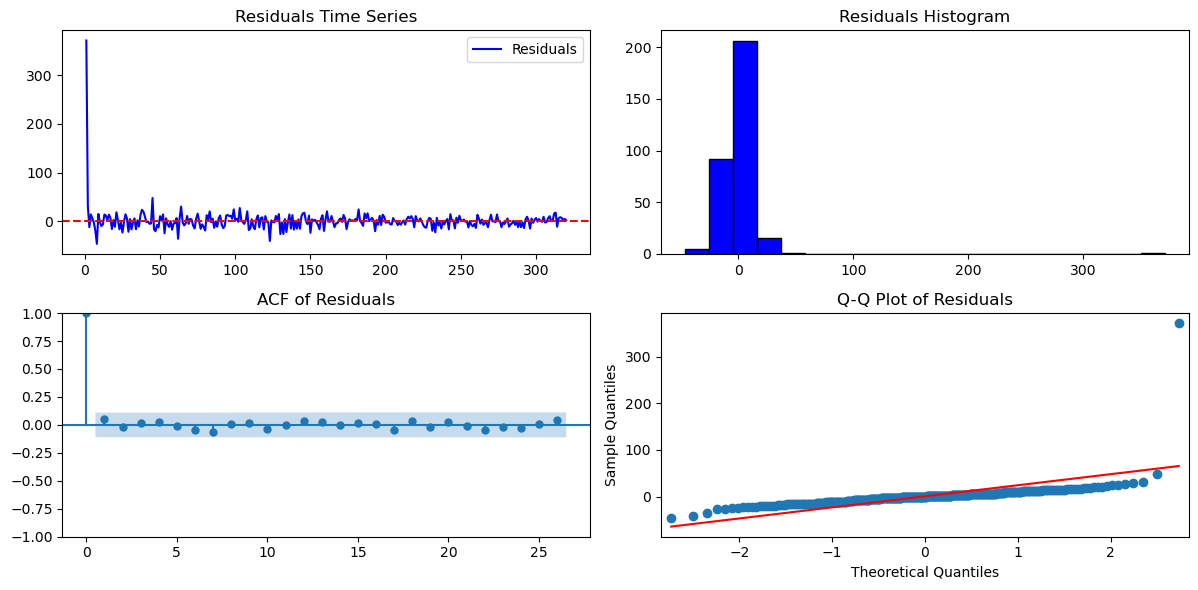

In [49]:
residuals = arima_result_0_1_0.resid
plt.figure(figsize=(12, 6))

# Residual time series plot
plt.subplot(2, 2, 1)
plt.plot(residuals, label="Residuals", color='blue')
plt.title("Residuals Time Series")
plt.axhline(0, linestyle="--", color="red")
plt.legend()

# Histogram of residuals
plt.subplot(2, 2, 2)
plt.hist(residuals, bins=20, edgecolor='black', color='blue')
plt.title("Residuals Histogram")

# ACF of residuals
plt.subplot(2, 2, 3)
plot_acf(residuals, ax=plt.gca(), title="ACF of Residuals")

# Q-Q plot for normality
plt.subplot(2, 2, 4)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title("Q-Q Plot of Residuals")

plt.tight_layout()
plt.show()

In [51]:
# Ljung-Box test for residual autocorrelation
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
ljung_box_result

,lb_stat,lb_pvalue
10,4.071291,0.944074


## Evaluation

C:\Users\Zuu Zuu Kyaw Shwe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


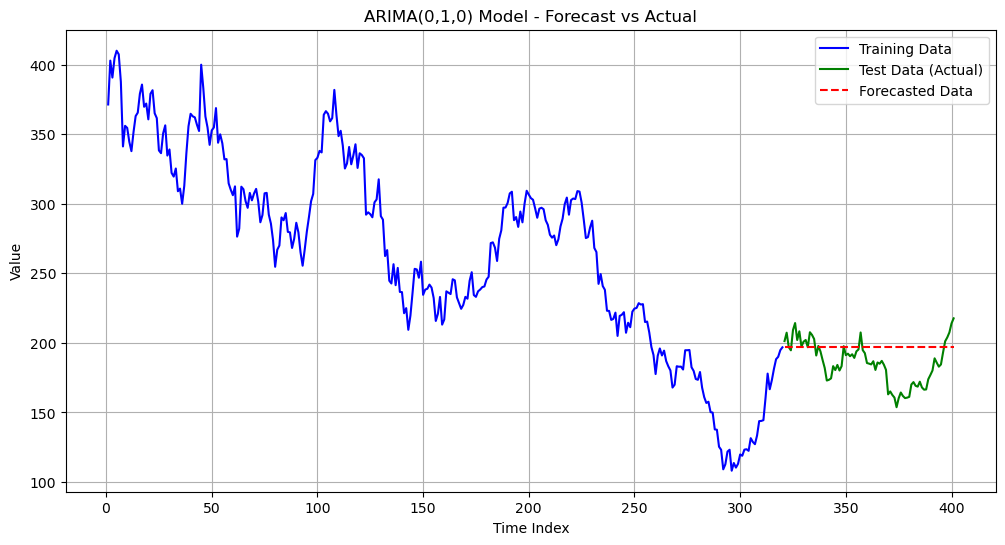

{'RMSE': 18.860270674117732, 'MAE': 15.208888677903301}

In [54]:
# Forecast the test data using the ARIMA(0,1,0) model
forecast_steps = len(test_data)  # Number of steps to forecast
forecast = arima_result_0_1_0.forecast(steps=forecast_steps)

# Plot the actual test data vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data['Value'], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['Value'], label='Test Data (Actual)', color='green')
plt.plot(test_data.index, forecast, label='Forecasted Data', color='red', linestyle='--')
plt.title('ARIMA(0,1,0) Model - Forecast vs Actual')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the forecast performance using RMSE and MAE
rmse = mean_squared_error(test_data['Value'], forecast, squared=False)
mae = mean_absolute_error(test_data['Value'], forecast)

{"RMSE": rmse, "MAE": mae}

## SARIMA Model Fitting

In [57]:
# Fit an SARIMA(0,1,0)(1,1,0,12) model
sarima_model = ARIMA(train_data['Value'], order=(0, 1, 0), seasonal_order=(1, 1, 0, 12))
sarima_result = sarima_model.fit()

sarima_summary = sarima_result.summary()
sarima_summary

C:\Users\Zuu Zuu Kyaw Shwe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Zuu Zuu Kyaw Shwe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Zuu Zuu Kyaw Shwe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            Value   No. Observations:                  320
Model:             ARIMA(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood               -1231.766
Date:                          Sat, 30 Nov 2024   AIC                           2467.533
Time:                                  14:37:34   BIC                           2474.987
Sample:                                       0   HQIC                          2470.514
                                          - 320                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.5391      0.044    -12.207      0.000      -0.626      -0.453
sigma2       176.4801     11.273     15.655      0.000     154.386     198.575
===================================================================================
Ljung-Box (L1) (Q):                   1.01   Jarque-Bera (JB):                43.67
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## SARIMA Model Diagnostics

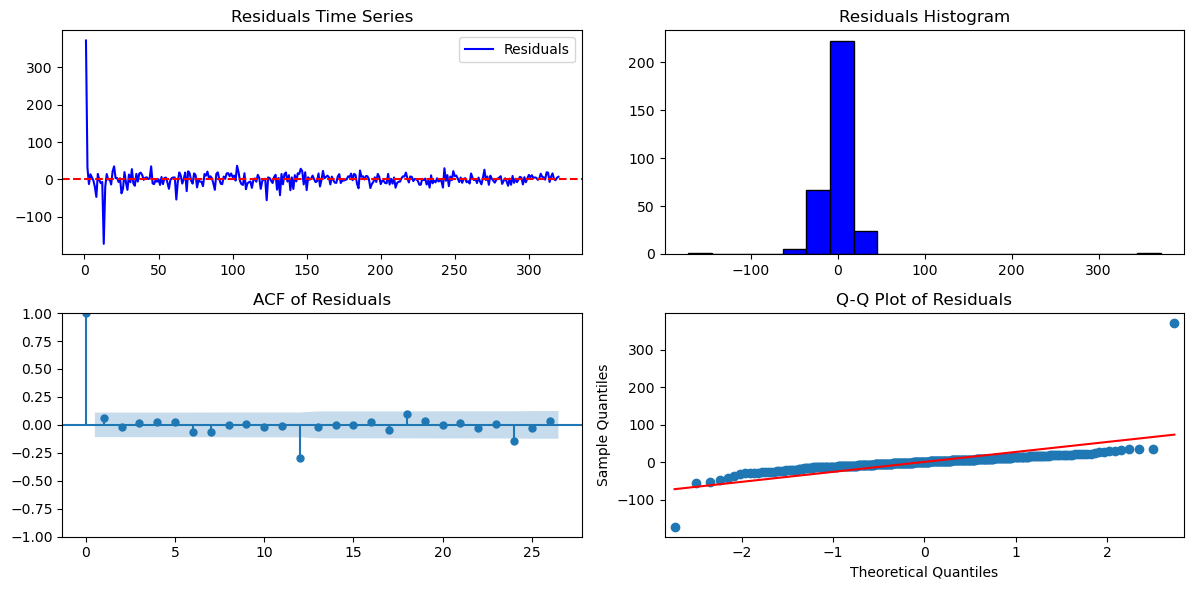

,lb_stat,lb_pvalue
10,4.4453,0.925031


In [60]:
sarima_residuals = sarima_result.resid
plt.figure(figsize=(12, 6))

# Residual time series plot
plt.subplot(2, 2, 1)
plt.plot(sarima_residuals, label="Residuals", color='blue')
plt.title("Residuals Time Series")
plt.axhline(0, linestyle="--", color="red")
plt.legend()

# Histogram of residuals
plt.subplot(2, 2, 2)
plt.hist(sarima_residuals, bins=20, edgecolor='black', color='blue')
plt.title("Residuals Histogram")

# ACF of residuals
plt.subplot(2, 2, 3)
plot_acf(sarima_residuals, ax=plt.gca(), title="ACF of Residuals")

# Q-Q plot for normality
plt.subplot(2, 2, 4)
sm.qqplot(sarima_residuals, line='s', ax=plt.gca())
plt.title("Q-Q Plot of Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for residual autocorrelation
ljung_box_sarima = acorr_ljungbox(sarima_residuals, lags=[10], return_df=True)
ljung_box_sarima

## SARIMA Model Evaluation

C:\Users\Zuu Zuu Kyaw Shwe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


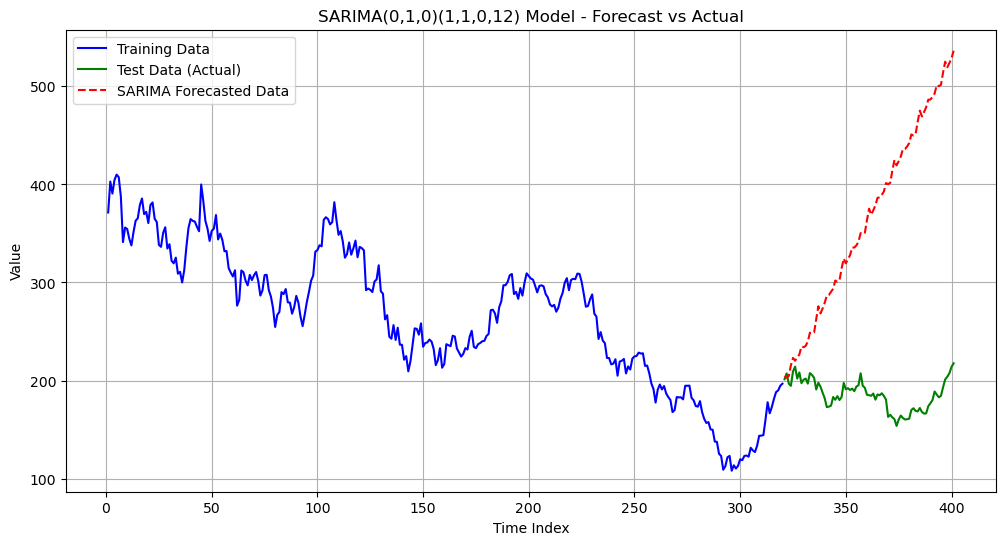

{'SARIMA RMSE': 208.4712596505594, 'SARIMA MAE': 180.27971935474451}

In [63]:
# Forecast the test data using the SARIMA model
sarima_forecast = sarima_result.forecast(steps=len(test_data))

# Plot the actual test data vs SARIMA forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data['Value'], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['Value'], label='Test Data (Actual)', color='green')
plt.plot(test_data.index, sarima_forecast, label='SARIMA Forecasted Data', color='red', linestyle='--')
plt.title('SARIMA(0,1,0)(1,1,0,12) Model - Forecast vs Actual')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the SARIMA forecast performance using RMSE and MAE
sarima_rmse = mean_squared_error(test_data['Value'], sarima_forecast, squared=False)
sarima_mae = mean_absolute_error(test_data['Value'], sarima_forecast)

{"SARIMA RMSE": sarima_rmse, "SARIMA MAE": sarima_mae}

## Comparative Analysis Between ARIMA & SARIMA

In [66]:
comparison_metrics = {
    "ARIMA (0,1,0)": {
        "RMSE": rmse,
        "MAE": mae
    },
    "SARIMA (0,1,0)(1,1,0,12)": {
        "RMSE": sarima_rmse,
        "MAE": sarima_mae
    }
}
comparison_df = pd.DataFrame(comparison_metrics).T
print(comparison_df)

                                RMSE         MAE
ARIMA (0,1,0)              18.860271   15.208889
SARIMA (0,1,0)(1,1,0,12)  208.471260  180.279719
